In [11]:
import monetdb.sql,pandas as pd,binet as bnt,numpy as np
def exportJS(varname,data):  
    fname = varname+'.js'
    f = open(fname,mode='w')
    f.write(('const '+varname+' = '+data.to_json(orient='records')+' \nexport default '+varname).encode('utf-8'))
    f.close()

connection = monetdb.sql.connect(username='monetdb', password='monetdb', hostname='a.media.mit.edu', database="pan2")
cursor = connection.cursor()

In [4]:
query = 'SELECT b.yr,t.cityid,b.branschagg,sum(b.prodvalue_adj) FROM setownbransch b INNER JOIN setowns t ON b.townid=t.townid WHERE not t.landsbygd GROUP BY b.yr,t.cityid,b.branschagg;'
cursor.execute(query)
data = pd.DataFrame(cursor.fetchall(),columns=['year','cityid','bcode','X'])

query = 'SELECT branschagg,branschname_en,grp FROM sebranschagg;'
cursor.execute(query)
bnames = pd.DataFrame(cursor.fetchall(),columns=['bcode','bname','bgroup'])

query = 'SELECT c.cityid,c.cityname,r.regionname FROM secities c INNER JOIN seregions r ON c.regionid=r.regionid WHERE not c.landsbygd;'
cursor.execute(query)
cnames = pd.DataFrame(cursor.fetchall(),columns=['cityid','cityname','regionname'])

In [5]:
net = bnt.calculateRCA(data,y='year',c='cityid',p='bcode',x='X')
net.loc[net['X']==0,'RCA'] = 0
net = net[net['RCA']>=1]

nYears = data[['year','bcode']].drop_duplicates().groupby('bcode').count()[['year']].rename(columns={'year':'nYears'}).reset_index()
R = bnt.countBoth(net,t='year',c='cityid',p='bcode')
R = R.groupby(['bcode','bcodep']).sum().drop('year',1).reset_index()
R = pd.merge(R,nYears,how='left')
R = pd.merge(R,nYears.rename(columns={'bcode':'bcodep','nYears':'nYearsp'}),how='left')
R['nYears'] = R[['nYears','nYearsp']].min(1)
R['Ns'] = R['N_bcode']*R['N_bcodep']
R = R.drop(['nYearsp','N_bcode','N_bcodep'],1)

R['Ns'] = np.log10(R['Ns']+1)
R['N_both'] = np.log10(R['N_both']+1)
R['nYears'] = np.log10(R['nYears'])

\begin{align}
    \log(R_{ii'}) = & \ \beta_0 + \beta_1 \log(R_i R_{i'}) + \beta_2 \log (\min\left\{ y_i,y_{i'}\right\}) + \gamma_{ii'}\\
    R_{ii'} = & \ \frac{1}{T} \sum_t \sum_r M_{ir}^{(t)} M_{i'r}^{(t)} \\
    R_i = & \ \frac{1}{T} \sum_{t} \sum_r M_{ir}^{(t)} \\    
    y_i = & \ \sum_t I(R_{i}^{(t)}>1)
\end{align}

In [6]:
fi = bnt.residualNet(R,s='bcode',t='bcodep',x='N_both',numericalControls=['Ns','nYears']).drop(['N_both','nYears','Ns'],1).rename(columns={'N_both_res':'fi'})
fi['fi'] = 10**(fi['fi'])

/Users/cristian/Dropbox (MIT)/binet/binet/functions.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_[x+'_res'] = Y-model.predict(X)


(array([1.832e+03, 2.582e+03, 1.020e+03, 3.040e+02, 7.200e+01, 2.400e+01,
        1.200e+01, 2.000e+00, 0.000e+00, 4.000e+00]),
 array([0.0241201 , 0.8259159 , 1.62771169, 2.42950748, 3.23130328,
        4.03309907, 4.83489487, 5.63669066, 6.43848645, 7.24028225,
        8.04207804]),
 <a list of 10 Patch objects>)

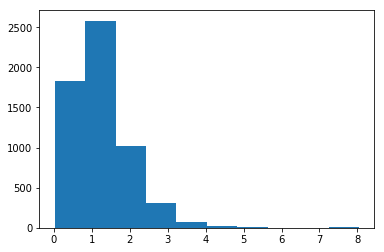

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(fi['fi'])

In [8]:
edges = bnt.build_connected(fi,fi['fi'].max(),s='bcode',t='bcodep')
nodes = bnt.communities(edges,s='bcode',t='bcodep',node_id='bcode')
edges = bnt.build_connected(fi,3.3,s='bcode',t='bcodep')
nodes = pd.merge(nodes,bnames,how='left')

Average degree: 1.97402597403
Number of communities: 10
Average degree: 2.41558441558


In [9]:
#This export is to construct the network in cytoscape
nodes.to_csv('rawNetwork/nodes.csv',encoding='utf-8',index=False)
edges.to_csv('rawNetwork/edges.csv',encoding='utf-8',index=False)
fi.to_csv('rawNetwork/edgesAll.csv',encoding='utf-8',index=False)

In [12]:
exportJS('links',edges.rename(columns={'bcode':'parentId','bcodep':'childId','fi':'weight'}))

Check cyto for correct network layout

In [13]:
nodes = pd.read_csv('rawNetwork/nodes.csv')

pos = bnt.readCyto('rawNetwork/pos.cyjs').rename(columns={'shared_name':'bcode'})
pos['bcode'] = pos['bcode'].astype(int)
nodes = pd.merge(nodes,pos,how='left')

nodes['x'] = (nodes['x'] - nodes['x'].min())/(nodes['x'].max() - nodes['x'].min())
nodes['y'] = (nodes['y'] - nodes['y'].min())/(nodes['y'].max() - nodes['y'].min())

In [14]:
exportJS('nodesPositions',nodes.rename(columns={'bcode':'id','bname':'name'})[['id','name','community_id','x','y']])

(-1, 1)

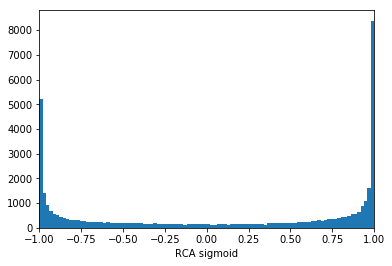

In [19]:
net = bnt.calculateRCA(data,y='year',c='cityid',p='bcode',x='X')
net = pd.merge(bnt.allCombinations(net,c='cityid',p='bcode',t='year'),net,how='left').fillna(0)
net.loc[net['X']==0,'RCA'] = 0
net['logX'] = np.log10(net['X']+1)
net['RCAsig'] = (net['RCA']**3-1.)/(net['RCA']**3+1)
net['RCAb'] = 0
net.loc[net['RCA']>=.1,'RCAb'] = 1
plt.hist(net[net['X']!=0]['RCAsig'],bins=100)
plt.xlabel('RCA sigmoid')
plt.xlim(-1,1)

In [20]:
net = pd.merge(net,cnames[['cityid','cityname']])

In [21]:
exportJS('nodesChanges',net[net['logX']>0][['year','cityname','bcode','RCAb','logX']].rename(columns={'RCAb':'activated','cityname':'city','bcode':'id','logX':'size'}))